data 출처 : https://github.com/songys/Chatbot_data

### GPT1 모델 구조 정의
- transformer에서 변경된 모델 구조

1. 인코더 삭제

2. 인코더 디코더 어텐션 삭제

3. 포지셔널 인코딩을 삭제하고 포지셔널 임베딩으로 대체

4. 활성화 함수 gelu 사용

In [333]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [334]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [335]:
# 멀티헤드어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수 사용
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

In [336]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

In [337]:
# 디코더 레이어 정의
def decoder_layer(units, d_model, num_heads, dropout, name = 'decoder_layer'):
    
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    
    attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
    attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
    attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs) # Residual 적용
    
    outputs = tf.keras.layers.Dense(units=units, activation='gelu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1) # Residual 적용

    return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [338]:
# 포지셔널 임베딩하고 디코더를 여러개 쌓는 함수
def decoder_stack(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            max_position_encoding,
            dropout,
            name='decoder'):

    inputs = tf.keras.Input(shape=(None,), name='inputs')
    look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    
    seq_len = tf.shape(inputs)[1] # 현재 시퀀스의 길이
    
    # 토큰 임베딩
    token_embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model, name='token_embedding')
    embeddings = token_embedding_layer(inputs)
    
    # 포지셔널 임베딩
    pos_embedding_layer = tf.keras.layers.Embedding(max_position_encoding,
                                                    d_model, name='positional_embedding')
    positions = tf.range(start=0, limit=seq_len, delta=1)
    positional_embeddings = pos_embedding_layer(positions)
    
    # 토큰 임베딩과 포지셔널 임베딩 합쳐줌
    embeddings += positional_embeddings 
    
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask])

    return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

In [339]:
# gpt의 디코더 모델 정의
# mask 작업도 해서 값을 디코더에 넣음
def gpt_decoder(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                max_position_encoding,
                name="gpt_decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    look_ahead_mask = tf.keras.layers.Lambda(
    create_look_ahead_mask,
    output_shape=(1, None, None),
    name='look_ahead_mask')(inputs)

    dec_outputs = decoder_stack(
    vocab_size=vocab_size,
    num_layers=num_layers,
    units=units,
    d_model=d_model,
    num_heads=num_heads,
    max_position_encoding=max_position_encoding,
    dropout=dropout,)(inputs=[inputs, look_ahead_mask])
    
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
    

### 데이터 전처리
- 변경된 데이터셋 구조
1. start, q, a, end_token으로 전체 문장 시작과 q 시작, a시작, 문장 끝을 알리는 토큰을 추가하고
하나의 시퀀스로 만듬

In [340]:
data_row = pd.read_csv('ChatbotData.csv')

In [341]:
data = data_row.copy()

In [342]:
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [343]:
data.dropna(inplace=True) # 결측치 제거
data.drop_duplicates(inplace=True) # 중복 제거

In [344]:
import re

def clean_text(text):
    text = re.sub(r'[^\w\s가-힣]', '', text)  # 특수문자 제거 (영어 포함 가능)
    text = re.sub(r'\s+', ' ', text).strip()  # 중복 공백 제거
    return text

data['Q'] = data['Q'].apply(clean_text)
data['A'] = data['A'].apply(clean_text)

In [345]:
data

,Q,A,label
0,12시 땡,하루가 또 가네요,0
1,1지망 학교 떨어졌어,위로해 드립니다,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠,0
4,PPL 심하네,눈살이 찌푸려지죠,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임,티가 나니까 눈치가 보이는 거죠,2
11819,훔쳐보는 것도 눈치 보임,훔쳐보는 거 티나나봐요,2
11820,흑기사 해주는 짝남,설렜겠어요,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까,잘 헤어질 수 있는 사이 여부인 거 같아요,2


In [346]:
questions = data['Q'].tolist()
answers = data['A'].tolist()

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers,
    target_vocab_size = len(data)
)

# vocab 확인
print("Vocabulary size:", tokenizer.vocab_size)

Vocabulary size: 10125


In [347]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, Q_TOKEN, A_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1], \
[tokenizer.vocab_size + 2], [tokenizer.vocab_size + 3]

print('START_TOKEN 번호 :' ,[tokenizer.vocab_size])
print('Q_TOKEN 번호 :' ,[tokenizer.vocab_size + 1])
print('A_TOKEN 번호 :' ,[tokenizer.vocab_size + 2])
print('END_TOKEN 번호 :' ,[tokenizer.vocab_size + 3])
VOCAB_SIZE = tokenizer.vocab_size + 4
print(VOCAB_SIZE)

START_TOKEN 번호 : [10125]
Q_TOKEN 번호 : [10126]
A_TOKEN 번호 : [10127]
END_TOKEN 번호 : [10128]
10129


In [348]:
def encode_sentence(sentence1, sentence2):
    return START_TOKEN + Q_TOKEN + tokenizer.encode(sentence1)+ A_TOKEN + tokenizer.encode(sentence2)+ END_TOKEN

In [349]:
encoded_sen = list(data.iloc[:, :2].apply(lambda x: encode_sentence(x["Q"], x["A"]), axis=1))

In [350]:
data

,Q,A,label
0,12시 땡,하루가 또 가네요,0
1,1지망 학교 떨어졌어,위로해 드립니다,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠,0
4,PPL 심하네,눈살이 찌푸려지죠,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임,티가 나니까 눈치가 보이는 거죠,2
11819,훔쳐보는 것도 눈치 보임,훔쳐보는 거 티나나봐요,2
11820,흑기사 해주는 짝남,설렜겠어요,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까,잘 헤어질 수 있는 사이 여부인 거 같아요,2


In [351]:
# 10125 : START_TOKEN, 10126 : Q_TOKEN, 10127 : A_TOKEN, 10128 : END_TOKEN
print("원본 질문:", data.iloc[0])
print("인코딩된 질문:", encoded_sen[0])

원본 질문: Q            12시 땡
A        하루가 또 가네요
label            0
Name: 0, dtype: object
인코딩된 질문: [10125, 10126, 6932, 3006, 4776, 10127, 3324, 67, 6912, 10128]


In [352]:
num_tokens = [len(tokens) for tokens in encoded_sen]
num_tokens = np.array(num_tokens)

In [353]:
MAX_LENGTH = np.max(num_tokens)

In [354]:
# 토큰화된 데이터에 패딩 추가
tokenized_data = tf.keras.preprocessing.sequence.pad_sequences(
      encoded_sen, maxlen=MAX_LENGTH, padding='post')

In [355]:
tokenized_data.shape

(11823, 38)

In [373]:
from sklearn.model_selection import train_test_split

X = tokenized_data[:, :-1]  # 입력 시퀀스는 END_TOKEN 빠짐
y = tokenized_data[:, 1:]   # 타겟 시퀀스는 START_TOKEN이 빠짐

# 8대2로 나눔
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [374]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 훈련 데이터셋
train_dataset = tf.data.Dataset.from_tensor_slices(({'inputs': X_train}, {'outputs': y_train}))
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 검증 데이터셋
val_dataset = tf.data.Dataset.from_tensor_slices(({'inputs': X_val}, {'outputs': y_val}))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [375]:
NUM_LAYERS = 4 # 인코더와 디코더의 층의 개수
D_MODEL = 128 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 4 # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 256 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt_decoder(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    max_position_encoding=max_len,
    dropout=DROPOUT,
    name='gpt_decoder_stack')

In [376]:
model.summary()

Model: "gpt_decoder_stack"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 128)    1831296     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 10129)  1306641     decoder[0][0]    

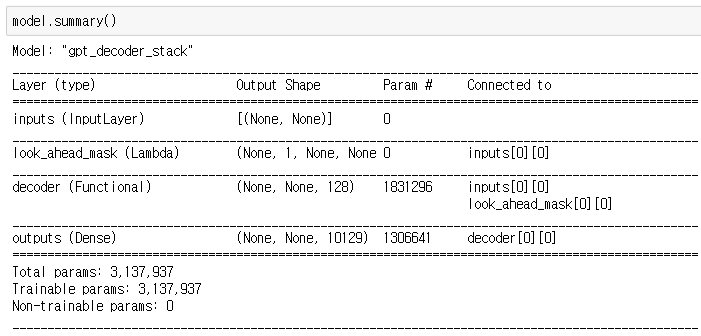

In [377]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

In [378]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

In [379]:
model.compile(optimizer=optimizer, loss=loss_function)

In [380]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=3,                # 3 에포크 동안 성능 향상이 없으면 학습 중단
    restore_best_weights=True  # 가장 좋은 모델 가중치를 복원
)

In [381]:
EPOCHS = 200
model.fit(train_dataset, validation_data = val_dataset, epochs=EPOCHS, callbacks = [early_stopping], verbose=1)

Epoch 1/200
148/148 [==============================] - 11s 40ms/step - loss: 2.9610 - val_loss: 2.8701
Epoch 2/200
148/148 [==============================] - 5s 34ms/step - loss: 2.7548 - val_loss: 2.6933
Epoch 3/200
148/148 [==============================] - 5s 34ms/step - loss: 2.5896 - val_loss: 2.5474
Epoch 4/200
148/148 [==============================] - 5s 34ms/step - loss: 2.4547 - val_loss: 2.4304
Epoch 5/200
148/148 [==============================] - 5s 34ms/step - loss: 2.3485 - val_loss: 2.3425
Epoch 6/200
148/148 [==============================] - 5s 34ms/step - loss: 2.2696 - val_loss: 2.2790
Epoch 7/200
148/148 [==============================] - 5s 34ms/step - loss: 2.2105 - val_loss: 2.2302
Epoch 8/200
148/148 [==============================] - 5s 34ms/step - loss: 2.1607 - val_loss: 2.1866
Epoch 9/200
148/148 [==============================] - 5s 34ms/step - loss: 2.1158 - val_loss: 2.1530
Epoch 10/200
148/148 [==============================] - 5s 34ms/step - loss: 2.08

148/148 [==============================] - 5s 34ms/step - loss: 1.2835 - val_loss: 1.8398
Epoch 81/200
148/148 [==============================] - 5s 34ms/step - loss: 1.2751 - val_loss: 1.8399
Epoch 82/200
148/148 [==============================] - 5s 34ms/step - loss: 1.2648 - val_loss: 1.8404


In [405]:
def predict_answer(question, tokenizer, model, max_length=MAX_LENGTH):
    # 1. 질문을 토큰화하여 입력 텍스트 준비
    question_encoded = tokenizer.encode(question)
    input_ids = [tokenizer.vocab_size + 1] + question_encoded  # <START_TOKEN> 추가

    # 2. 텍스트를 텐서로 변환
    input_tensor = tf.constant(input_ids, dtype=tf.int64)  # 입력 시퀀스를 텐서로 변환
    input_tensor = tf.expand_dims(input_tensor, 0)  # 배치 차원 추가 (배치 크기 1)

    # 3. 예측 시작
    generated_ids = []  # 시작 토큰을 제외한 예측된 토큰들을 저장할 리스트
    predicted_answer = []
    for _ in range(max_length - len(input_ids)):  # 최대 길이까지 예측
        # 모델 예측 (자기회귀적 예측)
        predictions = model(input_tensor, training=False)  # 모델 예측 (디코더 입력)

        # 예측된 값 중 가장 확률이 높은 토큰을 선택
        logits = predictions[:, -1, :]  # 마지막 타임스텝의 로짓
        predicted_token = tf.argmax(logits, axis=-1)  # 가장 확률이 높은 토큰 선택
        predicted_token = tf.cast(predicted_token, tf.int64)  # 정수로 형변환
        
        # 종료 토큰 <END_TOKEN>이 나오면 예측을 멈춘다
        if predicted_token == tokenizer.vocab_size + 4:  # <END_TOKEN> (vocab_size + 4)
            print('end_token 등장')
            break

        # 예측된 토큰을 입력 시퀀스에 추가
        input_tensor = tf.concat([input_tensor, tf.expand_dims(predicted_token, 0)], axis=-1)

        # 생성된 ID를 저장
        generated_ids.append(predicted_token.numpy()[0])  # 시작 토큰은 제외하고 저장
        
        temp = predicted_token.numpy()[0]
#         print(temp)
        if temp == 10125:
            decode_answer = 'start'
        elif temp == 10126:
            decode_answer = 'q'
        elif temp == 10127:
            decode_answer = 'a'
        elif temp == 10128:
            decode_answer = 'end'
        else:
            decode_answer = tokenizer.decode([temp])
        predicted_answer.append(decode_answer)
        
    # 4. 예측된 토큰을 디코딩하여 답변 생성
    print(generated_ids)
#     predicted_answer = tokenizer.decode(generated_ids)  # 시작 토큰 제외하고 디코딩
    return predicted_answer


In [411]:
question = "결혼이 뭐야"

# 답변 생성
answer = predict_answer(question, tokenizer, model)
print("Generated Answer:", ' '.join(answer))

[10127, 25, 232, 2, 22, 1, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128, 10128]
Generated Answer: a 사람  만날  수  있을  거예요 end end end end end end end end end end end end end end end end end end end end end end end end end end end end
